In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import os

In [ ]:
!pwd

/content


In [ ]:
!cd sample_data

In [ ]:
!ls

sample_data


In [ ]:
!git clone https://github.com/Kasra1377/face-mask-dataset.git

Cloning into 'face-mask-dataset'...
remote: Enumerating objects: 1670, done.
remote: Counting objects: 100% (1670/1670), done.
remote: Compressing objects: 100% (1669/1669), done.
remote: Total 1670 (delta 3), reused 1652 (delta 0), pack-reused 0
Receiving objects: 100% (1670/1670), 57.68 MiB | 26.36 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
cd /content/face-mask-dataset

/content/face-mask-dataset


In [ ]:
model=load_model("/content/face-mask-dataset/mask_detector.model")

In [ ]:
prototxtPath=os.path.sep.join(["/content/face-mask-dataset" ,"deploy.prototxt"])
weightsPath=os.path.sep.join(["/content/face-mask-dataset" ,"res10_300x300_ssd_iter_140000.caffemodel"])

In [ ]:
net=cv2.dnn.readNet(prototxtPath , weightsPath)

In [ ]:
def readImage(imagePath):
  image = cv2.imread(imagePath)
  image = cv2.resize(image , (400 , 300))
  h , w , _ = image.shape
  blob = cv2.dnn.blobFromImage(image,1.0,(300,300),(104.0,177.0,123.0))     # preprocessing the image
  net.setInput(blob)
  detections=net.forward()
  count_persons = 0
  count_mask = 0
  count_withoutmask = 0
  for i in range(0 , detections.shape[2]):
    confidence = detections[0,0,i,2]            # calculating the probability of whether the object is face or not
  
    if confidence > 0.5:                        # if the probability of an object is greater than 50% it will be accepted as face
        count_persons += 1
        box = detections[0,0,i,3:7] * np.array([w , h , w , h])
        (startX , startY , endX , endY) = box.astype("int")       # defining the bounding boxes of the face
        
        # ensure that the bounding boxes are place in the frame
        (startX , startY) = (max(0,startX) , max(0,startY))
        (endX , endY) = (min(w-1,endX) , min(h-1,endY))
        

        face = image[startY : endY, startX : endX]        # extracting the region of the interest of the image which is face
        face = cv2.cvtColor(face , cv2.COLOR_BGR2RGB)
        face = cv2.resize(face , (224 , 224))
        face = img_to_array(face)
        face = preprocess_input(face)
        face = np.expand_dims(face,axis = 0)              # expanding the image shape by one to feed it to the neural network
        (mask , withoutMask) = model.predict(face)[0]
        
        if mask > withoutMask:
          label = "Mask"
          count_mask += 1
        else:
          label = "No Mask"
          count_withoutmask += 1

        color = (0 , 255 , 0) if label == "Mask" else (0 , 0 , 255)
        label = "{}: {:.2f}%".format(label , max(mask , withoutMask) * 100)     # placing the label confidence next to the class name
        
        cv2.putText(image , label , (startX , startY-10) , cv2.FONT_HERSHEY_SIMPLEX , 0.45 , color , 2)
        cv2.rectangle(image , (startX , startY) , (endX , endY) , color , 2)  

  cv2.putText(image , "Person(s) : {}".format(count_persons) , (0 , h - 30) , cv2.FONT_HERSHEY_SIMPLEX , 0.45 , (0 , 255 , 255) , 1)
  cv2.putText(image , "With mask : {}".format(count_mask) , (0 , h - 15) , cv2.FONT_HERSHEY_SIMPLEX , 0.45 , (0 , 255 , 255) , 1)
  cv2.putText(image , "Without mask : {}".format(count_withoutmask)  , (0 , h) , cv2.FONT_HERSHEY_SIMPLEX , 0.45 , (0 , 255 , 255) , 1)      
  
  cv2_imshow(image)
  cv2.waitKey(0)
  cv2.destroyAllWindows()

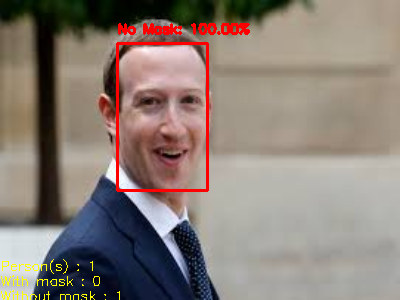

In [ ]:
readImage(imagePath = "/content/face-mask-dataset/image-samples/example-05.jpg")